In [2]:
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dateutil

In [37]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 
                            1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', 
                                  sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')
animal_phenotypes.set_index('animal', inplace=True)

In [40]:
animal_phenotypes.loc[1060, 'OGTT (AUC)']

1761.75

In [33]:
df.set_index?

In [38]:
animal_phenotypes


,Date of birth,lcms_sampled,glucose_tolerance,10.6g dextrose in 6mL distilled water; total 12.5mL solution,OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),OGTT (AUC),HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,
1060,2021-01-23,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,1761.75,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1061,2021-01-23,False,NaN,48.0,196.5,344.5,449.5,518.0,284.5,1674.80,NaN,1.7808,1.751032,0.6059,0.595772,2.939099,murky,Slight,NaN
1062,2021-01-23,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,1648.75,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
1063,2021-01-23,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5485,2.333791,0.8614,0.788828,2.958556,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1074,2021-01-23,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,1350.25,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
1075,2021-01-23,False,NaN,169.0,355.0,600.0,600.0,569.5,392.0,3365.00,NaN,1.3107,1.242370,0.5910,0.560190,2.217766,White,Yes,NaN
1076,2021-01-23,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,2321.25,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
1080,2021-01-24,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9369,1.727832,0.7754,0.691704,2.497937,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1081,2021-01-24,False,NaN,171.0,345.0,547.0,600.0,563.0,428.5,2354.75,NaN,1.3511,1.193551,0.6283,0.555035,2.150406,White,No,NaN


In [17]:
df = fr_filt
df2 = np.log2(df[fr_quant_filenames_in_analytical_order].T)
fg = file_grouping[file_grouping['fr_name'].isin(fr_quant_filenames_in_analytical_order)]
fg = fg.reset_index()[['fr_name', 'rat_label', 'bg_type', 'glucose_tolerance', 'bg']].set_index('fr_name')
df = df2.join(fg)
ogtt_lookup = animal_phenotypes[['animal', 'OGTT (AUC)']]
df['ogtt'] = df['rat_label'].apply(lambda x: ogtt_lookup[ogtt_lookup['animal'] == (int(x))]['OGTT (AUC)'].values[0])
# rename columns to remove '.' because it messes with the formula notation 
new_cols = {}
for col in df.columns:
    new_cols[col] = col.replace('.', '').replace(':', '').replace('-', '')\
    .replace('[', '').replace(']', '')
df = df.rename(new_cols, axis=1)
display(df)

,unknown_67905463_0536,unknown_6411087_0537,unknown_95115973_0541,unknown_32903067_0542,unknown_96913147_0544,unknown_62313641_0546,unknown_29108359_0551,unknown_35299652_0553,unknown_24709372_0554,unknown_60514441_0555,...,unknown_89782532_20148,unknown_9749118_20163,unknown_59358716_20175,unknown_87180945_20196,unknown_100393829_20435,rat_label,bg_type,glucose_tolerance,bg,ogtt
20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,18.897008,16.810111,17.724121,18.400646,16.655211,1076.0,FBG,diabetic,71.000000,2321.25
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.348489,17.364343,19.240306,18.585339,16.313637,1062.0,FBG,impaired,52.333333,1648.75
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,21.529536,20.099612,21.430516,20.968101,19.339229,1093.0,FBG,normal,64.000000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,17.921098,18.430542,17.488155,16.202162,17.985491,1060.0,RBG,impaired,225.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.133479,17.986741,19.996615,19.778245,17.357845,1091.0,FBG,normal,48.500000,846.75
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,17.824376,18.099621,17.383197,15.556400,17.582655,1092.0,RBG,impaired,70.500000,1377.95
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,18.836779,18.145468,18.282680,16.603878,17.887551,1093.0,RBG,normal,69.500000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,19.255315,14.496938,19.507853,19.379093,13.846921,1082.0,FBG,diabetic,50.000000,2224.75
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.261890,18.854601,17.718258,16.494586,18.466842,1060.0,RBG,impaired,83.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,19.685160,18.324624,19.526233,18.844052,17.739443,1101.0,FBG,diabetic,43.000000,2015.75


In [130]:
random_col = random.choice(df.drop(df.filter(regex='unknown').columns, axis=1).columns)
print(random_col)

lmem_continuous = smf.mixedlm(f"{random_col} ~ ogtt * bg_type", df, groups=df['rat_label']).fit(maxiter=100)
print(lmem_continuous.summary(), "\n\n")

lmem_categorical = smf.mixedlm(f"{random_col} ~ glucose_tolerance * bg_type", df, groups=df['rat_label']).fit(maxiter=100)
print(lmem_categorical.summary())



TG_181_180_225_95283173_17462
                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TG_181_180_225_95283173_17462
No. Observations: 60      Method:             REML                         
No. Groups:       10      Scale:              0.6920                       
Min. group size:  6       Log-Likelihood:     -91.9544                     
Max. group size:  6       Converged:          Yes                          
Mean group size:  6.0                                                      
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                20.257      0.733   27.631   0.000   18.820   21.694
bg_type[T.RBG]           -0.458      0.781   -0.587   0.557   -1.988    1.072
ogtt                      0.001      0.000    1.346   0.178   -0.00

In [131]:
lmem_continuous.random_effects

{1060.0: Group   -0.122147
 dtype: float64,
 1062.0: Group    0.255703
 dtype: float64,
 1074.0: Group   -0.017708
 dtype: float64,
 1076.0: Group    0.270427
 dtype: float64,
 1082.0: Group   -0.098571
 dtype: float64,
 1091.0: Group   -0.006484
 dtype: float64,
 1092.0: Group   -0.422922
 dtype: float64,
 1093.0: Group    0.148831
 dtype: float64,
 1101.0: Group   -0.497521
 dtype: float64,
 1102.0: Group    0.49039
 dtype: float64}

TG_181_180_225_95283173_17462
Intercept              20.257019
bg_type[T.RBG]         -0.458325
ogtt                    0.000583
ogtt:bg_type[T.RBG]     0.000999
Group Var               0.254737
dtype: float64


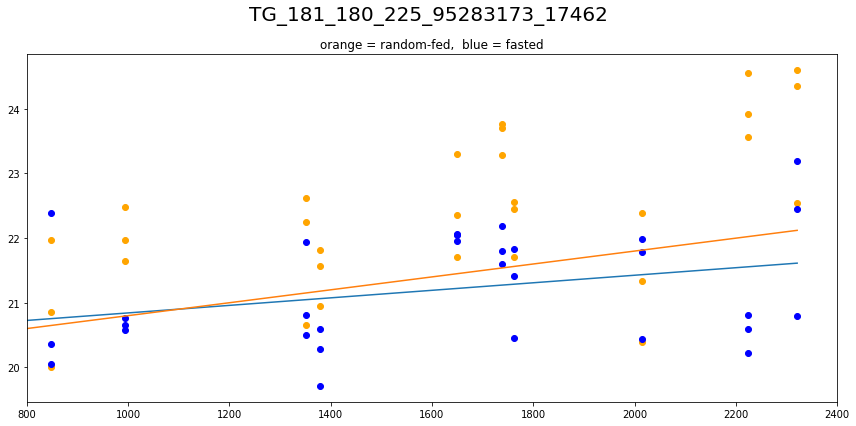

In [132]:
print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(111)
    ax.set_xlim((800, 2400))
    ogtt_value = animal_phenotypes.loc[animal, 'OGTT (AUC)']
    ax.set_title('orange = random-fed,  blue = fasted', fontsize=12)
#     ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ['Random', 'Fasted'])
    data = df[[random_col, 'rat_label', 'bg_type', 'ogtt']]
    
    for j, bg_type in enumerate(['RBG', 'FBG']):
        color = 'orange' if j == 0 else 'blue'
        ax.scatter(3*[ogtt_value], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type), color=color)

intercept = lmem_continuous.params['Intercept']
bg_typeTRBG = lmem_continuous.params['bg_type[T.RBG]']
ogtt = lmem_continuous.params['ogtt']
ogttbgtype = lmem_continuous.params['ogtt:bg_type[T.RBG]']
re = lmem_continuous.random_effects

plt.plot([0, 2321.25], [intercept, intercept + 2321.25 * ogtt])  
plt.plot([0, 2321.25], [(intercept + bg_typeTRBG), (intercept + bg_typeTRBG) + 2321.25 * (ogttbgtype)])

        
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()
print(lmem_continuous.params)

TG_535_88476996_15942


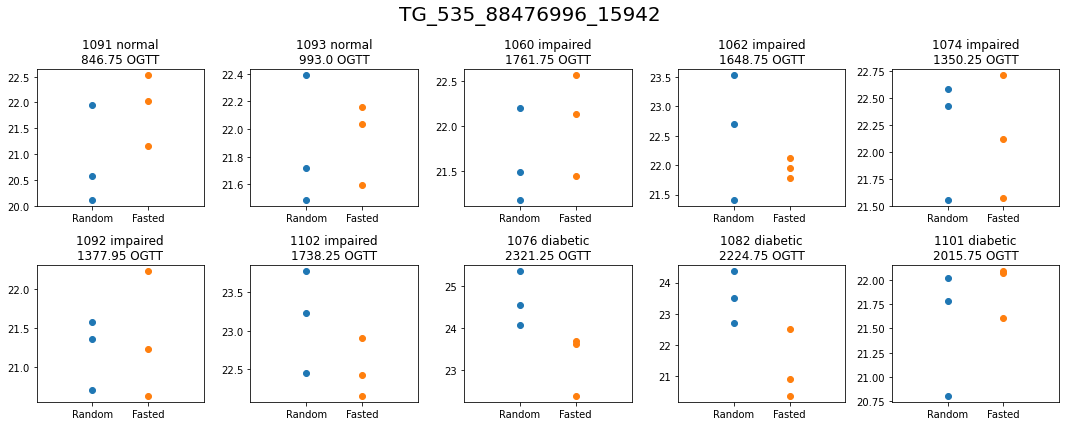

In [45]:
print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(2, 5, i+1, )
    ax.set_xlim((0,3))
    ogtt_value = animal_phenotypes.loc[animal, 'OGTT (AUC)']
    ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
    ax.set_xticks([1,2])
    ax.set_xticklabels( ['Random', 'Fasted'])
    for j, bg_type in enumerate(['RBG', 'FBG']):
        
        ax.scatter(3*[j+1], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type))
        
        
# plt.xticks(range(1,11), [str(animal) for animal in animals_used]);
fig = plt.gcf()
fig.set_size_inches(15, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()